In [34]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import os
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
config_path = "configs_yeast"


In [36]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [37]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [38]:
ds = dtds.dsFromFile(data_file)
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Yeast


In [39]:
samples_trans, lnprobs = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


In [40]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

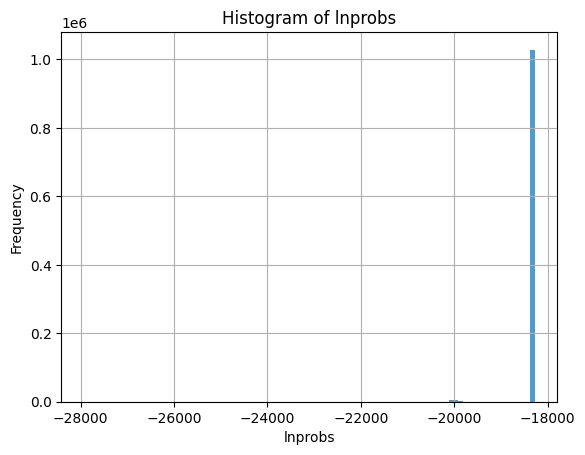

In [43]:
#plot a histogram of lnprobs2
thresh =-np.inf
plt.hist(lnprobs[lnprobs>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

(16,)


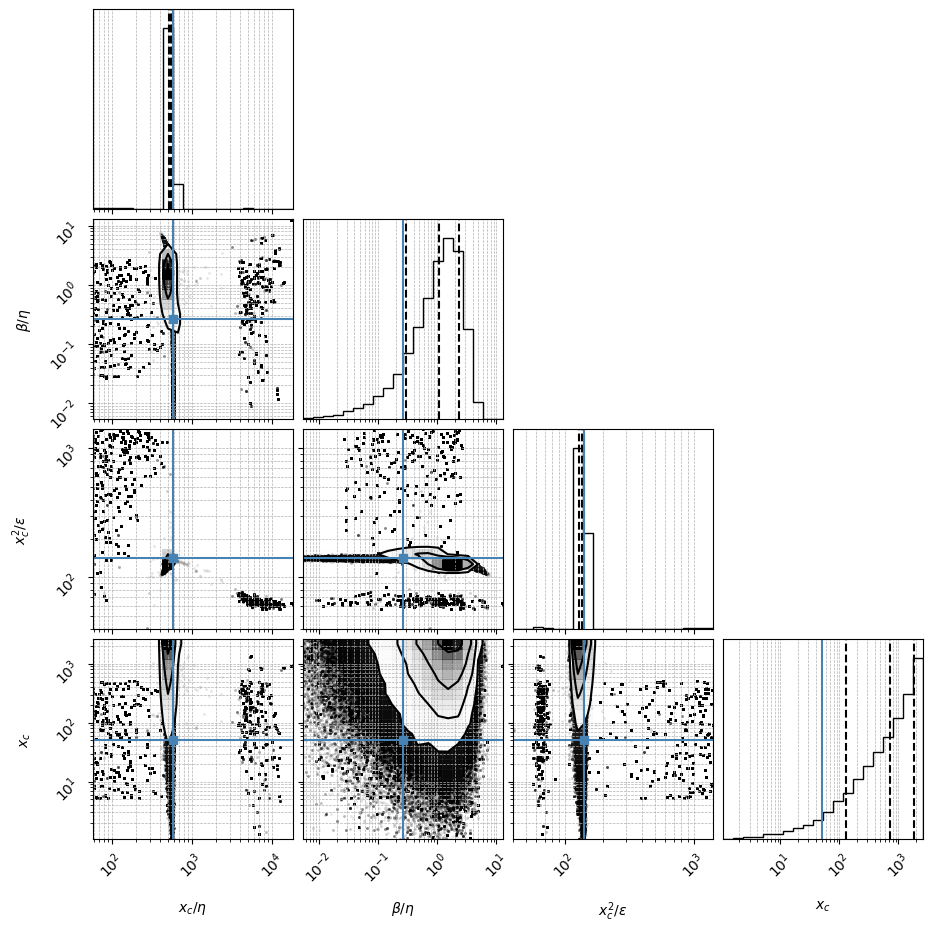

In [44]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], axes_scale='log',quantiles=[0.16, 0.5, 0.84],truths=seed_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

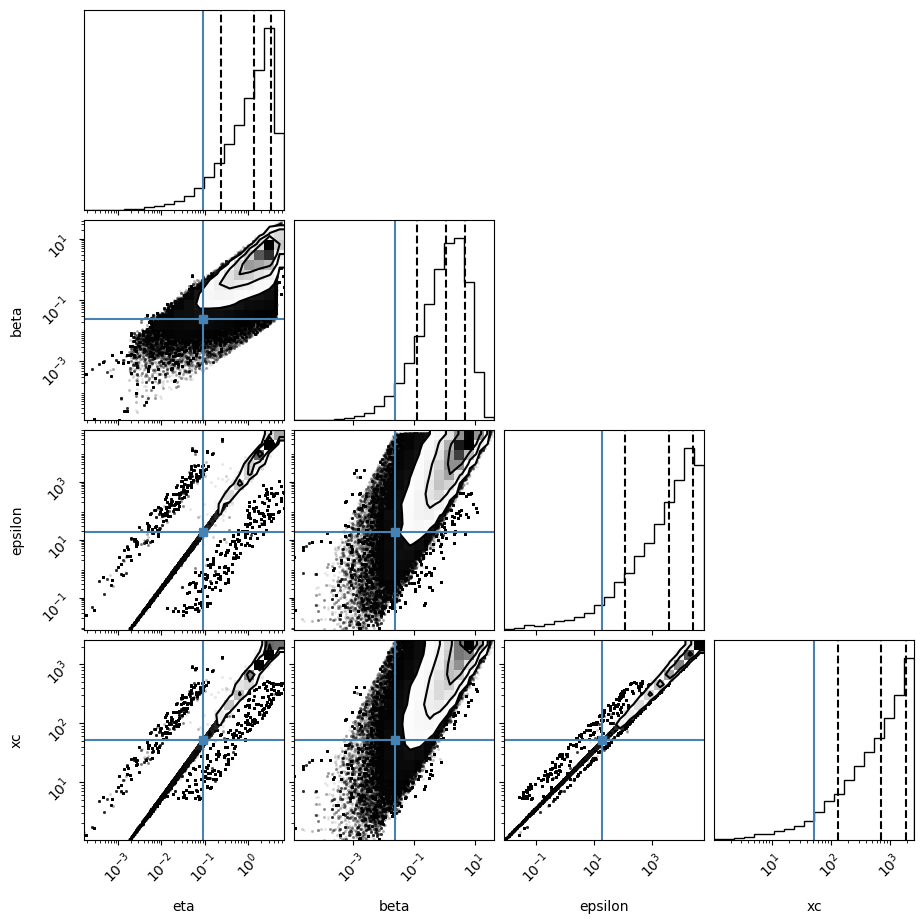

In [45]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc'],axes_scale='log',quantiles=[0.16, 0.5, 0.84],truths=seed)

In [46]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=None,ref_theta=seed,percent=False)

                            Eta  Beta   Epsilon      Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps    Fk/Dk  Fk^2/Dk  t_eta  Median Lifetime
Best fit                   1.29  2.54   3459.47  679.11      1.98         0.50              0.0074                  0.0150    133.31         0.00037                  10.07                   27386.94                   5.800           0.25000    0.20  0.00037  0.00370  22.99            25.87
Median                     1.35  1.08   3868.50  722.13      1.07         0.27              0.0021                  0.0078    136.02         0.00018                   2.09                   12148.62                   5.770           0.25000    0.19  0.00018  0.00055  23.54            25.87
Mean                       1.71  2.38  10645.88  922.43      1.30         0.45              0.0054                  0.0099    1

In [ ]:
#print for dfb a table that show for each colume if abs(mean - ref) > std
ref = dfb.loc['Mean - ref']
mean = dfb.loc['Mean']
std = dfb.loc['Std']

comparison = (abs(ref) >   std)
print("******1 STD comparison********")
print("number of vals not in 1 std errorbar =", np.sum(comparison))

print(comparison)

******1 STD comparison********
number of vals not in 1 std errorbar =  2
Eta                           True
Beta                         False
Epsilon                      False
Xc                            True
Beta/Eta                     False
Beta*Xc/Eps                  False
Fx=Beta^2/(Eta*Xc)           False
Dx=Beta*Eps/(Eta*Xc^2)       False
Xc^2/Eps                     False
Beta*Kappa/Eps               False
Fk=Beta^2/(Eta*Kappa)        False
Dk=Beta*Eps/(Eta*Kappa^2)    False
s=(Xc^1.5*Eta^0.5)/Eps       False
Slope=Eta*Xc/Eps             False
Xc/Eps                       False
Fk/Dk                        False
Fk^2/Dk                      False
t_eta                        False
Median Lifetime              False
dtype: bool


In [ ]:
#print for dfb a table that show for each colume if abs(mean - ref) > 2*std
ref = dfb.loc['Mean - ref']
mean = dfb.loc['Mean']
std = dfb.loc['Std']

comparison = (abs(ref) >   2*std)
print("******2 STD comparison********")
print("number of vals not in 2 std errorbar =", np.sum(comparison))

print(comparison)

******2 STD comparison********
number of vals not in 2 std errorbar =  0
Eta                          False
Beta                         False
Epsilon                      False
Xc                           False
Beta/Eta                     False
Beta*Xc/Eps                  False
Fx=Beta^2/(Eta*Xc)           False
Dx=Beta*Eps/(Eta*Xc^2)       False
Xc^2/Eps                     False
Beta*Kappa/Eps               False
Fk=Beta^2/(Eta*Kappa)        False
Dk=Beta*Eps/(Eta*Kappa^2)    False
s=(Xc^1.5*Eta^0.5)/Eps       False
Slope=Eta*Xc/Eps             False
Xc/Eps                       False
Fk/Dk                        False
Fk^2/Dk                      False
t_eta                        False
Median Lifetime              False
dtype: bool
